<a href="https://colab.research.google.com/github/lariskelmer/TinyML/blob/main/week_08/LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LeNet-5

Perhaps the first widely known and successful application of convolutional neural networks was **LeNet-5**, described by Yann LeCun, et al. in their 1998 paper titled [Gradient-Based Learning Applied to Document Recognition](https://ieeexplore.ieee.org/document/726791). The system was developed for use in a handwritten character recognition problem and demonstrated on the **MNIST standard dataset**, achieving approximately 99.2% classification accuracy (or a 0.8% error rate). The network was then described as the central technique in a broader system referred to as **Graph Transformer Networks**.

It is a long paper, and perhaps the best part to focus on is Section II. B. that describes the LeNet-5 architecture. In that section, the paper describes the **network as having seven layers** with input **grayscale images** having the shape **32 x 32**, the size of images in the **MNIST dataset**. 

> The model proposes a pattern of a convolutional layer followed by an average pooling layer, referred to as a **subsampling layer**. 

This pattern is repeated two and a half times before the output feature maps are flattened and fed to some fully connected layers for interpretation and a final prediction. A picture of the network architecture is provided in the paper and reproduced below.

<img width="800" src="https://drive.google.com/uc?export=view&id=1nqbLzHfqorX80I8upHMWINwPNfrmLW-V"/>

The pattern of blocks of convolutional layers and pooling layers (referred to as **subsampling**) grouped and repeated **remains a typical pattern in designing and using convolutional neural networks today, more than twenty years later**. Interestingly, the architecture uses a small number of filters with a modest size as the first hidden layer, specifically 6 filters, each with 5x5 pixels. After pooling, another convolutional layer has many more filters, again with the same size, precisely 16 filters with 5x5 pixels, again followed by pooling. In the repetition of these two blocks of convolution and pooling layers, the trend increases the number of filters.

Compared to modern applications, the number of filters is also small, but **the trend of increasing the number of filters with the depth of the network also remains a common pattern in modern usage of the technique.** The flattening of the feature maps and interpretation and classification of the extracted features by fully connected layers also remains a common pattern today. 

> In modern terminology, the **final section of the architecture** is often referred to as the **classifier**, whereas the **convolutional and pooling layers** earlier in the model are referred to as the **feature extractor**.

We can summarize the key aspects of the architecture relevant in modern models as follows:

- Fixed-sized input images.
- Group convolutional and pooling layers into blocks.
- Repetition of convolutional-pooling blocks in the architecture.
- Increase in the number of filters with the depth of the network.
- Distinct feature extraction and classifier parts of the architecture.

## Step 01: Setup

Start out by installing the experiment tracking library and setting up your free W&B account:


*   **pip install wandb** – Install the W&B library
*   **import wandb** – Import the wandb library
*   **wandb login** – Login to your W&B account so you can log all your metrics in one place

In [1]:
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 34.0 MB/s 
     |████████████████████████████████| 166 kB 69.6 MB/s 
     |████████████████████████████████| 182 kB 56.4 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 166 kB 74.1 MB/s 
     |████████████████████████████████| 162 kB 76.3 MB/s 
     |████████████████████████████████| 162 kB 73.9 MB/s 
     |████████████████████████████████| 158 kB 72.0 MB/s 
     |████████████████████████████████| 157 kB 67.2 MB/s 
     |████████████████████████████████| 157 kB 70.6 MB/s 
     |████████████████████████████████| 157 kB 74.6 MB/s 
     |████████████████████████████████| 157 kB 76.2 MB/s 
     |████████████████████████████████| 157 kB 54.2 MB/s 
     |████████████████████████████████| 157 kB 72.8 MB/s 
     |████████████████████████████████| 157 kB 77.9 MB/s 
     |████████████████████████████████| 156 kB 77.5 MB/s 


In [2]:
# a Python package for tracking the carbon emissions produced by various
# kinds of computer programs, from straightforward algorithms to deep neural networks.
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 37.7 MB/s 
     |████████████████████████████████| 66 kB 5.6 MB/s 
     |████████████████████████████████| 46 kB 4.8 MB/s 


### Import Packages

In [3]:
# import the necessary packages
import logging
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from codecarbon import EmissionsTracker
from tensorflow.keras.callbacks import Callback
from wandb.keras import WandbCallback
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import wandb
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

## Step 02: Implementing LeNet-5


<img width="800" src="https://drive.google.com/uc?export=view&id=1RF_HWPSImajab-i1ayFeEOoFON0Ky-28"/>

Source code based on **Rosebrock, Adrian. Deep Learning For Computer vision with Python, 2019** [link](https://pyimagesearch.com/deep-learning-computer-vision-python-book/)

In [6]:
class LeNet:
  ''' 
  # create LeNet-5 model
  #
  # it is composed of the 8 layers (5 layers considering FC as one layer) 
  # such as:
  #      - 2 convolutional layers
  #      - 2 subsampling (avg pooling) layers
  #      - 1 flatten layer
  #      - 2 fully connected layers
  #      - 1 output layer with 10 outputs
  '''
  @staticmethod
  def build(width, height, depth, classes):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    
    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
   
    # first set of CONV => RELU => POOL layers
    model.add(Conv2D(6, (5,5), strides=1, padding='same',
                     activation='tanh', input_shape=(28,28,1), )) #C1
    model.add(AveragePooling2D()) #S2

    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(16, (5,5), strides=1, padding='valid',
                     activation='tanh')) #C3
    model.add(AveragePooling2D()) #S4

    # a flatten and two set of FC => RELU layers
    model.add(Flatten()) #Flatten
    model.add(Dense(120, activation='tanh')) #C5
    model.add(Dense(84, activation='tanh')) #F6

    # softmax classifier
    model.add(Dense(10, activation='softmax')) #Output layer
    
    # return the constructed network architecture
    return model

In [7]:
# create a model object
model = LeNet.build(28,28,1,10)

# summarize layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

## Step 03: LeNet-5 on MNIST

### Fetch, Preprocessing and Data Segregation

In [8]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "lenet-5"
}

In [9]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="ufrn-embai",
                 project=args["project_name"], 
                 job_type="Train")

wandb: Currently logged in as: lariskelmer (ufrn-embai). Use `wandb login --relogin` to force relogin


In [10]:
# grab the MNIST dataset (if this is your first time using this
# dataset then the 11MB download may take a second)
logger.info("[INFO] accessing MNIST...")
((train_x, train_y), (test_x, test_y)) = mnist.load_data()

logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))

10-11-2022 00:40:16 [INFO] accessing MNIST...


11490434/11490434 [==============================] - 1s 0us/step


10-11-2022 00:40:18 Train x: (60000, 28, 28)
10-11-2022 00:40:18 Train y: (60000,)
10-11-2022 00:40:18 Test x: (10000, 28, 28)
10-11-2022 00:40:18 Test y: (10000,)


In [11]:
# if we are using "channels first" ordering, then reshape the
# design matrix such that the matrix is:
# num_samples x depth x rows x columns
if K.image_data_format() == "channels_first":
	train_x = train_x.reshape((train_x.shape[0], 1, 28, 28))
	test_x = test_x.reshape((test_x.shape[0], 1, 28, 28))
 
# otherwise, we are using "channels last" ordering, so the design
# matrix shape should be: num_samples x rows x columns x depth
else:
	train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
	test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))

In [12]:
logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))

10-11-2022 00:40:18 Train x: (60000, 28, 28, 1)
10-11-2022 00:40:18 Train y: (60000,)
10-11-2022 00:40:18 Test x: (10000, 28, 28, 1)
10-11-2022 00:40:18 Test y: (10000,)


In [13]:
# scale data to the range of [0, 1]
train_x = train_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0

# convert the labels from integers to vectors
lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)
test_y = lb.transform(test_y)

### Training

In [14]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# initialize the optimizer and model
logger.info("[INFO] compiling model...")
opt = Adam(learning_rate=0.01)
model = LeNet.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

# train the network
logger.info("[INFO] training network...")
history = model.fit(train_x, train_y,
              validation_data=(test_x, test_y),
              batch_size=32,
              epochs=20, 
              verbose=0,
              callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                   compute_flops=True)])

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

10-11-2022 00:40:19 [INFO] compiling model...
10-11-2022 00:40:19 [INFO] training network...
10-11-2022 00:40:20 From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/nn_ops.py:5219: tensor_shape_from_node_def_name (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


### Evaluation Metrics

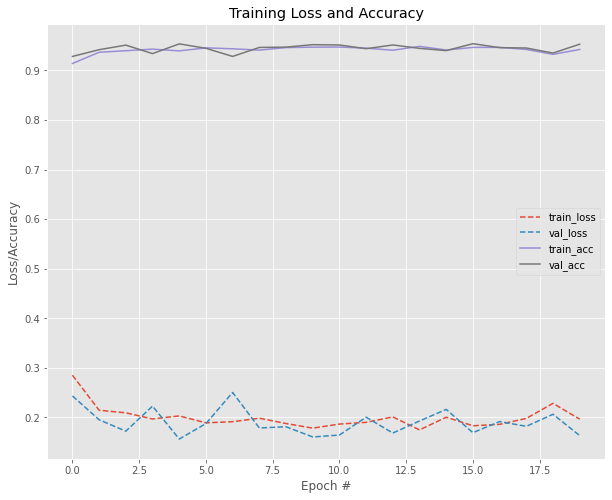

In [15]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 20), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [16]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

[INFO] 0.00303595589686538 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.00018877800792242293 kWh
[INFO] Energy consumed for all GPU: 0.001158996009157631 kWh
[INFO] Energy consumed for all CPU: 0.001688181879785326 kWh
[INFO] CO2 emission 0.0009654339752031909(in Kg)


In [17]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(test_x, batch_size=32)
print(classification_report(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[str(i) for i in lb.classes_]))

[INFO] evaluating network...
313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       980
           1       0.98      0.97      0.97      1135
           2       0.95      0.96      0.96      1032
           3       0.97      0.95      0.96      1010
           4       0.97      0.93      0.95       982
           5       0.94      0.95      0.94       892
           6       0.94      0.98      0.96       958
           7       0.96      0.95      0.95      1028
           8       0.93      0.93      0.93       974
           9       0.90      0.94      0.92      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



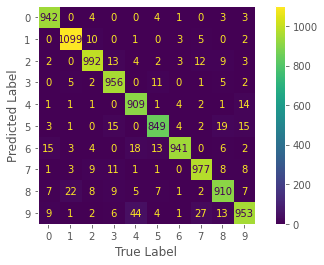

In [18]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predictions.argmax(axis=1),
                                        test_y.argmax(axis=1)),
                       display_labels=lb.classes_).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [19]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

10-11-2022 00:42:46 Uploading figures


In [20]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(test_y.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(test_y.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(test_y.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

10-11-2022 00:42:46 Validation Evaluation metrics
10-11-2022 00:42:46 Validation Accuracy: 0.9528
10-11-2022 00:42:46 Validation Precision: 0.9534474908627415
10-11-2022 00:42:46 Validation Recall: 0.9528
10-11-2022 00:42:46 Validation F1: 0.952914442262709


In [21]:
run.finish()

accuracy,▁▆▆▇▆▇▇▆▇██▇▆█▇██▇▅▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▂▃▂▂▃▂▁▂▂▃▁▃▂▂▂▄▂
val_accuracy,▁▅▇▃█▅▁▆▆▇▇▅▇▅▄█▆▆▃█
val_loss,▇▄▂▆▁▃█▃▃▁▂▄▂▄▅▂▄▃▅▂
Acc,0.9528
CO2_Emissions,0.00097
Count_Params,61706
Energy_CPU,0.00169
Energy_Consumed,0.00304
Energy_GPU,0.00116


# Data Augmentation

According to [Goodfellow et al.](https://www.deeplearningbook.org/), regularization is

> “(...) any modification we make to a learning algorithm that is intended to reduce its generalization error, but not its training error”

In short, regularization seeks to reduce our testing error perhaps at the expense of increasing training error slightly.

We’ve already looked at different forms of regularization in the first part of this course; however, these were parameterized forms of regularization, requiring us to update our loss/update
function. In fact, there exist other types of regularization that either:

1. Modify the network architecture itself.
2. Augment the data passed into the network for training.

**Dropout** is a great example of modifying a network architecture by achieving greater generalizability. Here we insert a layer that randomly disconnects nodes from the previous layer to the next layer, thereby ensuring that no single node is responsible for learning how to represent a given class.

In this section we’ll be discussing another type of regularization called **data augmentation**. This method purposely perturbs training examples, changing their appearance slightly, before passing them into the network for training. The end result is that a network consistently sees “new” training data points generated from the original training data, partially alleviating the need for us to gather more training data (though in general, gathering more training data will rarely hurt your algorithm).

**Data augmentation** encompasses a wide range of techniques used to generate new training samples from the original ones by applying random jitters and perturbations such that the classes labels are
not changed. 

> Our goal when applying **data augmentation** is to increase the generalizability of the model. 

Given that our network is constantly seeing new, slightly modified versions of the input data points, it’s able to learn more robust features. 

> At testing time, we do not apply data augmentation
and evaluate our trained network – in most cases, you’ll see an increase in testing accuracy, perhaps at the expense at a slight dip in training accuracy.

<center><img width="600" src="https://drive.google.com/uc?export=view&id=1PWNBYi_ziF8YnCCd25vnmsf9nxq-KsGH"></center><center><b>Left</b>: A sample of 250 data points that follow a normal distribution exactly. <b>Right</b>: Adding a small amount of random “jitter” to the distribution. This type of data augmentation can
increase the generalizability of our networks.</center>


Let’s consider the Figure above (**left**) of a normal distribution with zero mean and unit variance. Training a machine learning model on this data may result in us modeling the distribution exactly –
however, in real-world applications, data rarely follows such a neat distribution.

Instead, to increase the generalizability of our classifier, we may first randomly jitter points along the distribution by adding some values e drawn from a random distribution (**right**). Our plot
still follows an **approximately normal distribution**, but it’s not a perfect distribution as on the left. A model trained on this data is more likely to generalize to example data points not included in the
training set.
  **In the context of computer vision, data augmentation lends itself naturally**. For example, we can obtain additional training data from the original images by apply simple geometric transforms such as random:

1. Translations
2. Rotations
3. Changes in scale
4. Shearing
5. Horizontal (and in some cases, vertical) flips

Applying a (small) amount of these transformations to an input image will change its appearance slightly, but it does not change the class label – thereby making data augmentation a very natural, easy method to apply to deep learning for computer vision tasks.

### Fetch, Preprocessing and Data Segregation

In [22]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "lenet-5"
}

In [23]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="ufrn-embai",
                 project=args["project_name"], 
                 job_type="Train")

In [24]:
# grab the MNIST dataset (if this is your first time using this
# dataset then the 11MB download may take a second)
logger.info("[INFO] accessing MNIST...")
((train_x, train_y), (test_x, test_y)) = mnist.load_data()

# if we are using "channels first" ordering, then reshape the
# design matrix such that the matrix is:
# num_samples x depth x rows x columns
if K.image_data_format() == "channels_first":
	train_x = train_x.reshape((train_x.shape[0], 1, 28, 28))
	test_x = test_x.reshape((test_x.shape[0], 1, 28, 28))
 
# otherwise, we are using "channels last" ordering, so the design
# matrix shape should be: num_samples x rows x columns x depth
else:
	train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
	test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))

logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))

10-11-2022 00:42:57 [INFO] accessing MNIST...
10-11-2022 00:42:58 Train x: (60000, 28, 28, 1)
10-11-2022 00:42:58 Train y: (60000,)
10-11-2022 00:42:58 Test x: (10000, 28, 28, 1)
10-11-2022 00:42:58 Test y: (10000,)


In [25]:
# visualize 18 numbers
def show_image(train_image, label, index):
    plt.subplot(3, 6, index+1)
    plt.imshow(tf.squeeze(train_image), cmap=plt.cm.gray)
    plt.title(label)
    plt.grid(b=False)

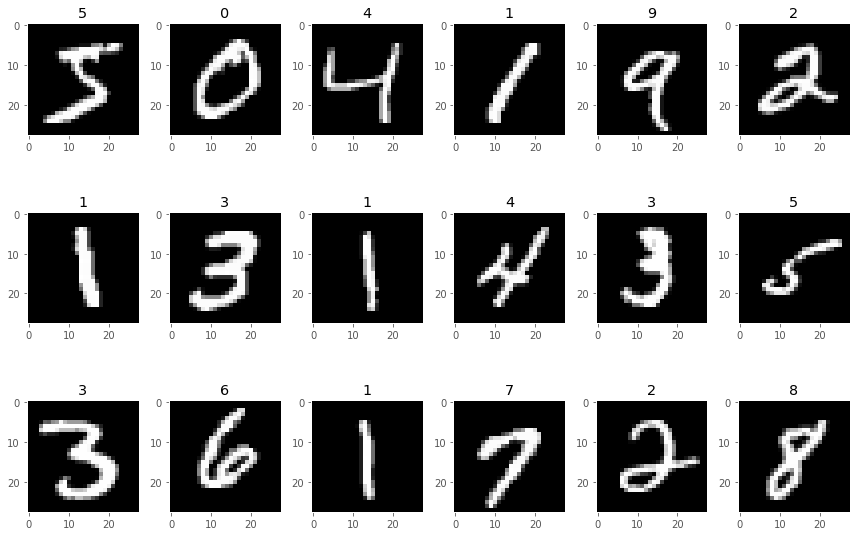

In [26]:
# visualize the first 18 numbers
plt.figure(figsize=(12, 8))
for index in range(18):
    label = train_y[index]
    image_pixels = train_x[index,:,:,:]
    show_image(image_pixels, label, index)
plt.tight_layout()

[INFO] generating images...


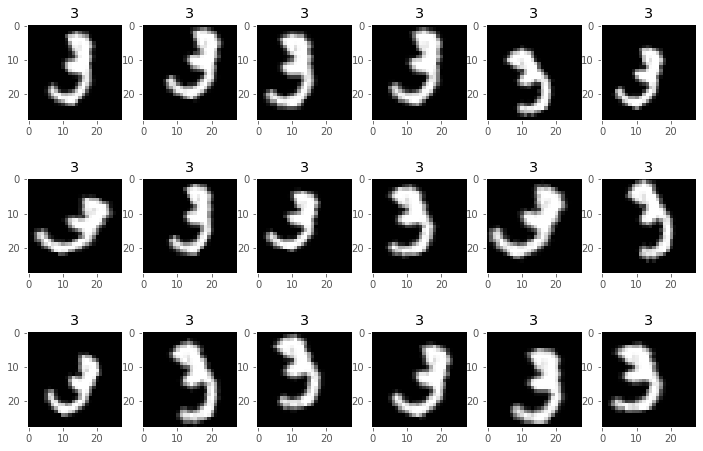

In [27]:
# construct the image generator for data augmentation then
# initialize the total number of images generated thus far
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=False, fill_mode="nearest")
total = 0
image = train_x[10:11,:,:,:]

# construct the actual Python generator
print("[INFO] generating images...")
imageGen = aug.flow(image, batch_size=1)

# create a figure
plt.figure(figsize=(12, 8))

# loop over examples from our image data augmentation generator
for img in imageGen:

  show_image(img, train_y[10], total)

  # increment our counter
  total += 1

  # if we have reached 10 examples, break from the loop
  if total == 18:
    break

In [28]:
# scale data to the range of [0, 1]
train_x = train_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0

# convert the labels from integers to vectors
lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)
test_y = lb.transform(test_y)

### Training

In [29]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# initialize the optimizer and model
logger.info("[INFO] compiling model...")
opt = Adam(learning_rate=0.01)
model = LeNet.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

# construct the image generator for data augmentation then
# initialize the total number of images generated thus far
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, 
                         zoom_range=0.2,
                         horizontal_flip=False, fill_mode="nearest")

# train the network
logger.info("[INFO] training network...")
history = model.fit(aug.flow(train_x, train_y, batch_size=32),
                    validation_data=(test_x, test_y),
                    epochs=20, 
                    verbose=0,
                    callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                         compute_flops=True)])

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

10-11-2022 00:43:03 [INFO] compiling model...
10-11-2022 00:43:04 [INFO] training network...


### Evaluation Metrics

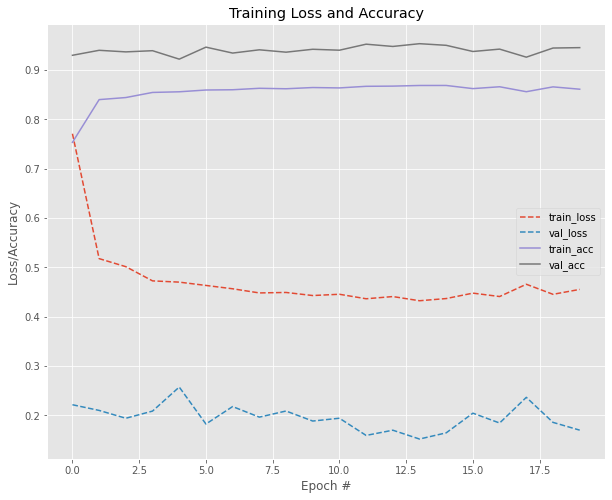

In [30]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 20), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [31]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

[INFO] 0.009660671881801247 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.0006069917448430791 kWh
[INFO] Energy consumed for all GPU: 0.003624506004313032 kWh
[INFO] Energy consumed for all CPU: 0.005429174132645131 kWh
[INFO] CO2 emission 0.0030720936584127966(in Kg)


In [32]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(test_x, batch_size=32)
print(classification_report(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[str(i) for i in lb.classes_]))

[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       980
           1       0.99      0.97      0.98      1135
           2       0.92      0.97      0.94      1032
           3       0.91      0.98      0.94      1010
           4       0.95      0.95      0.95       982
           5       0.97      0.92      0.95       892
           6       0.97      0.95      0.96       958
           7       0.98      0.87      0.92      1028
           8       0.95      0.91      0.93       974
           9       0.90      0.94      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.95      0.94      0.94     10000
weighted avg       0.95      0.94      0.94     10000



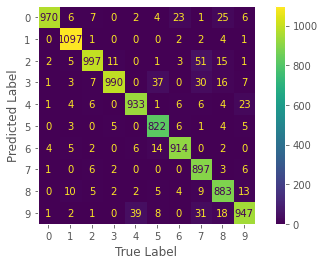

In [33]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predictions.argmax(axis=1),
                                        test_y.argmax(axis=1)),
                       display_labels=lb.classes_).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [34]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

10-11-2022 00:50:45 Uploading figures


In [35]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(test_y.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(test_y.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(test_y.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

10-11-2022 00:50:45 Validation Evaluation metrics
10-11-2022 00:50:45 Validation Accuracy: 0.945
10-11-2022 00:50:45 Validation Precision: 0.9463832133620502
10-11-2022 00:50:45 Validation Recall: 0.945
10-11-2022 00:50:45 Validation F1: 0.9449174741861043


In [36]:
run.finish()

accuracy,▁▆▇▇▇▇▇██████████▇██
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁
val_accuracy,▃▅▄▅▁▆▄▅▄▅▅█▇█▇▄▆▂▆▆
val_loss,▆▅▄▅█▃▅▄▅▃▄▁▂▁▂▄▃▇▃▂
Acc,0.945
CO2_Emissions,0.00307
Count_Params,61706
Energy_CPU,0.00543
Energy_Consumed,0.00966
Energy_GPU,0.00362


# Extensions

This section lists some ideas for extending that you may wish to explore.

- **Batch normalization**. Implement BN technique after the CONV Layer review the final result.
- **Dropout**. Analyze the use of regularization based on dropout technique and placed with different intensity after the Pooling layer.
- **Other activation functions**. Investigate change the activation function to relu and compare the results.


## Implementing IvanNet

<img width="800" src="https://drive.google.com/uc?export=view&id=1zi4EZQdcDtUqp_bA8qaiE6etd-N0NJPP"/>

Source code based on **Rosebrock, Adrian. Deep Learning For Computer vision with Python, 2019** [link](https://pyimagesearch.com/deep-learning-computer-vision-python-book/)

In [37]:
class IvaNet:
  ''' 
  # create IvanNet-5 model
  #
  # it is composed of the 8 layers (5 layers considering FC as one layer) 
  # such as:
  #      - 2 convolutional layers
  #      - 2 subsampling (avg pooling) layers
  #      - 1 flatten layer
  #      - 2 fully connected layers
  #      - 1 output layer with 10 outputs
  #      - 2 batchnormalization layers
  #      - 4 dropout layers
  '''
  @staticmethod
  def build(width, height, depth, classes):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    
    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
   
    # first set of CONV => RELU => POOL layers
    model.add(Conv2D(6, (5,5), strides=1, padding='same',
                     activation='tanh', input_shape=(28,28,1), )) #C1
    model.add(BatchNormalization())
    model.add(AveragePooling2D()) #S2
    model.add(Dropout(0.25))

    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(16, (5,5), strides=1, padding='valid',
                     activation='tanh')) #C3
    model.add(BatchNormalization())
    model.add(AveragePooling2D()) #S4
    model.add(Dropout(0.25))

    # a flatten and two set of FC => RELU layers
    model.add(Flatten()) #Flatten
    model.add(Dense(120, activation='tanh')) #C5
    model.add(Dropout(0.5))
    model.add(Dense(84, activation='tanh')) #F6
    model.add(Dropout(0.5))

    # softmax classifier
    model.add(Dense(10, activation='softmax')) #Output layer
    
    # return the constructed network architecture
    return model

In [38]:
# create a model object
model = IvaNet.build(28,28,1,10)

# summarize layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 6)        24        
 ormalization)                                                   
                                                                 
 average_pooling2d_6 (Averag  (None, 14, 14, 6)        0         
 ePooling2D)                                                     
                                                                 
 dropout (Dropout)           (None, 14, 14, 6)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 batch_normalization_1 (Batc  (None, 10, 10, 16)      

## Fetch, Preprocessing and Data Segregation

In [39]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "lenet-5"
}

In [41]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="ufrn-embai",
                 project=args["project_name"], 
                 job_type="Train")

Problem at: <ipython-input-41-a221f6ee1b02> 4 <module>


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_init.py", line 1078, in init
    run = wi.init()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_init.py", line 574, in init
    manager._inform_init(settings=self.settings, run_id=self.settings.run_id)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_manager.py", line 170, in _inform_init
    svc_iface._svc_inform_init(settings=settings, run_id=run_id)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/service/service_sock.py", line 38, in _svc_inform_init
    self._sock_client.send(inform_init=inform_init)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/lib/sock_client.py", line 211, in send
    self.send_server_request(server_req)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/lib/sock_client.py", line 155, in send_server_request
    self._send_message(msg)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/lib/sock_client.py",

Exception: ignored

In [ ]:
# grab the MNIST dataset (if this is your first time using this
# dataset then the 11MB download may take a second)
logger.info("[INFO] accessing MNIST...")
((train_x, train_y), (test_x, test_y)) = mnist.load_data()

logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))

In [ ]:
# if we are using "channels first" ordering, then reshape the
# design matrix such that the matrix is:
# num_samples x depth x rows x columns
if K.image_data_format() == "channels_first":
	train_x = train_x.reshape((train_x.shape[0], 1, 28, 28))
	test_x = test_x.reshape((test_x.shape[0], 1, 28, 28))
 
# otherwise, we are using "channels last" ordering, so the design
# matrix shape should be: num_samples x rows x columns x depth
else:
	train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
	test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))

In [ ]:
logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))

In [ ]:
# scale data to the range of [0, 1]
train_x = train_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0

# convert the labels from integers to vectors
lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)
test_y = lb.transform(test_y)

## Training

In [ ]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# initialize the optimizer and model
logger.info("[INFO] compiling model...")
opt = Adam(learning_rate=0.01)
model = IvaNet.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

# train the network
logger.info("[INFO] training network...")
history = model.fit(train_x, train_y,
              validation_data=(test_x, test_y),
              batch_size=32,
              epochs=20, 
              verbose=0,
              callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                   compute_flops=True)])

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

## Evaluation Metrics

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 20), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [ ]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(test_x, batch_size=32)
print(classification_report(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[str(i) for i in lb.classes_]))

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predictions.argmax(axis=1),
                                        test_y.argmax(axis=1)),
                       display_labels=lb.classes_).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

In [ ]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(test_y.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(test_y.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(test_y.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

In [ ]:
run.finish()

#LarissaNet

In [8]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "larissanet-5"
}

In [9]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="ufrn-embai",
                 project=args["project_name"], 
                 job_type="Train")

wandb: Currently logged in as: lariskelmer (ufrn-embai). Use `wandb login --relogin` to force relogin


In [18]:
sweep_config = {
    'method': 'grid'
    }
metric={
        'name': 'loss',
        'goal': 'minimize'
    }
parameters_dict = {
    'optimizer': {
        'values':['adam', 'relu', 'tanh']
    },
    'dropout':{
        'values':[0.1, 0.5, 1.0]
    },
    'batch_norm': {
        'values':[True, False]
    }
}
sweep_config['metric'] = metric
sweep_config['parameters'] = parameters_dict


In [19]:
sweep_id = wandb.sweep(sweep_config, entity="ufrn-embai", project=args["project_name"])


Create sweep with ID: sz0m4wqt
Sweep URL: https://wandb.ai/ufrn-embai/larissanet-5/sweeps/sz0m4wqt


In [20]:
class larissaNet:
  ''' 
  # create IvanNet-5 model
  #
  # it is composed of the 8 layers (5 layers considering FC as one layer) 
  # such as:
  #      - 2 convolutional layers
  #      - 2 subsampling (avg pooling) layers
  #      - 1 flatten layer
  #      - 2 fully connected layers
  #      - 1 output layer with 10 outputs
  #      - 2 batchnormalization layers
  #      - 4 dropout layers
  '''
  @staticmethod
  def build(width, height, depth, classes, activation = None, dropout = None, batch = None):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    
    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
   
    # first set of CONV => RELU => POOL layers
    if activation != None:
      model.add(Conv2D(6, (5,5), strides=1, padding='same',
                     activation=activation, input_shape=(28,28,1), )) #C1
    if batch != None:
      model.add(BatchNormalization())
    model.add(AveragePooling2D()) #S2
    if dropout!=None:
      model.add(Dropout(dropout))

    # second set of CONV => RELU => POOL layers
    if activation != None:
      model.add(Conv2D(16, (5,5), strides=1, padding='valid',
                     activation=activation)) #C3
    if batch != None:
      model.add(BatchNormalization())
    model.add(AveragePooling2D()) #S4
    if dropout!=None:
      model.add(Dropout(dropout))

    # a flatten and two set of FC => RELU layers
    model.add(Flatten()) #Flatten
    if activation != None:
      model.add(Dense(120, activation=activation)) #C5
    if dropout!=None:
      model.add(Dropout(0.5))
      model.add(Dense(84, activation=activation)) #F6
      model.add(Dropout(0.5))

    # softmax classifier
    model.add(Dense(10, activation='softmax')) #Output layer
    
    # return the constructed network architecture
    return model

In [25]:
model = larissaNet.build(width=28, height=28, depth=1, classes=10, activation_function = wandb.config.activation_function, batch_norm = wandb.config.batch_norm, dropout = wandb.config.dropout)

AttributeError: ignored

In [26]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(config=None):
    # Initialize a new wandb run
    with wandb.init(entity="ufrn-embai",
                   project=args["project_name"], 
                   job_type="Train"):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config
        
        # create codecarbon tracker
        # codecarbon is too much verbose, change the log level for more info
        tracker = EmissionsTracker(log_level="critical")
        tracker.start()

        # initialize the optimizer and model
        logger.info("[INFO] compiling model...")
        opt = Adam(learning_rate=0.01)
        model = larissaNet.build(width=28, height=28, depth=1, classes=10, activation_function = wandb.config.activation_function, batch_norm = wandb.config.batch_norm, dropout = wandb.config.dropout)
        model.compile(loss="categorical_crossentropy", optimizer=opt,
                      metrics=["accuracy"])

        # train the network
        logger.info("[INFO] training network...")
        history = model.fit(train_x, train_y,
              validation_data=(test_x, test_y),
              batch_size=32,
              epochs=20, 
              verbose=0,
              callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                   compute_flops=True)])

        # get co2 emissions from tracker
        # "CO2 emission (in Kg)"
        emissions = tracker.stop()

        # plot the training loss and accuracy
        plt.style.use("ggplot")
        fig, ax = plt.subplots(1,1,figsize=(10,8))

        ax.plot(np.arange(0, 20), history.history["loss"], label="train_loss",linestyle='--')
        ax.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss",linestyle='--')
        ax.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
        ax.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
        ax.set_title("Training Loss and Accuracy")
        ax.set_xlabel("Epoch #")
        ax.set_ylabel("Loss/Accuracy")
        ax.legend()
        plt.show()

        # evaluate the network
        print("[INFO] evaluating network...")
        predictions = model.predict(test_x, batch_size=32)
        print(classification_report(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[str(i) for i in lb.classes_]))

        fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
        ConfusionMatrixDisplay(confusion_matrix(predictions.argmax(axis=1),
                                                test_y.argmax(axis=1)),
                              display_labels=lb.classes_).plot(values_format=".0f",ax=ax)

        ax.set_xlabel("True Label")
        ax.set_ylabel("Predicted Label")
        ax.grid(False)
        plt.show()

        # Uploading figures
        logger.info("Uploading figures")
        run.log(
            {
                "confusion_matrix": wandb.Image(fig_confusion_matrix),
                # "other_figure": wandb.Image(other_fig)
            }
        )

        # Evaluation Metrics
        logger.info("Validation Evaluation metrics")
        fbeta = fbeta_score(test_y.argmax(axis=1), 
                            predictions.argmax(axis=1), 
                            beta=1, zero_division=1,average='weighted')
        precision = precision_score(test_y.argmax(axis=1),
                                    predictions.argmax(axis=1),
                                    zero_division=1,average='weighted')
        recall = recall_score(test_y.argmax(axis=1),
                              predictions.argmax(axis=1),
                              zero_division=1,average='weighted')
        acc = accuracy_score(test_y.argmax(axis=1),
                            predictions.argmax(axis=1))

        logger.info("Validation Accuracy: {}".format(acc))
        logger.info("Validation Precision: {}".format(precision))
        logger.info("Validation Recall: {}".format(recall))
        logger.info("Validation F1: {}".format(fbeta))

        run.summary["Acc"] = acc
        run.summary["Precision"] = precision
        run.summary["Recall"] = recall
        run.summary["F1"] = fbeta
        # number of parameters
        run.summary["Count_Params"] = model.count_params()
        # energy unit is kWh
        run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
        run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
        run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
        run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
        # kg
        run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions


In [27]:
wandb.agent(sweep_id, train, count = 5)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: 8jb3zxko with config:
wandb: 	batch_norm: True
wandb: 	dropout: 0.1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


10-11-2022 02:46:56 [INFO] compiling model...


wandb: ERROR Run 8jb3zxko errored: AttributeError("'<class 'wandb.sdk.wandb_config.Config'>' object has no attribute 'activation_function'")
wandb: Agent Starting Run: k89lhxyl with config:
wandb: 	batch_norm: True
wandb: 	dropout: 0.1
wandb: 	optimizer: relu
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


10-11-2022 02:47:15 [INFO] compiling model...


wandb: ERROR Run k89lhxyl errored: AttributeError("'<class 'wandb.sdk.wandb_config.Config'>' object has no attribute 'activation_function'")
wandb: Agent Starting Run: sejmpsnf with config:
wandb: 	batch_norm: True
wandb: 	dropout: 0.1
wandb: 	optimizer: tanh
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


10-11-2022 02:47:36 [INFO] compiling model...


wandb: ERROR Run sejmpsnf errored: AttributeError("'<class 'wandb.sdk.wandb_config.Config'>' object has no attribute 'activation_function'")
wandb: Agent Starting Run: 32k4esn2 with config:
wandb: 	batch_norm: True
wandb: 	dropout: 0.5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


10-11-2022 02:47:58 [INFO] compiling model...


wandb: ERROR Run 32k4esn2 errored: AttributeError("'<class 'wandb.sdk.wandb_config.Config'>' object has no attribute 'activation_function'")
wandb: Agent Starting Run: xiahhn8k with config:
wandb: 	batch_norm: True
wandb: 	dropout: 0.5
wandb: 	optimizer: relu
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


10-11-2022 02:48:21 [INFO] compiling model...


wandb: ERROR Run xiahhn8k errored: AttributeError("'<class 'wandb.sdk.wandb_config.Config'>' object has no attribute 'activation_function'")


Error in callback <function _WandbInit._pause_backend at 0x7f540a5cca70> (for post_run_cell):


BrokenPipeError: ignored